In [1]:
import sys
sys.path.insert(0,'../../src')
sys.path.insert(0,'../../src/models')
ROOT_DIR = '../../Data/'
from utilities import *  
from training_and_prediction import *

C:\Users\nicol\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# functions...

In [2]:
def is_foregroungund_surrounded(image, nbr_patches):
    '''turn foreground into street if it is surrounded'''
    for row in range(1,nbr_patches-1):
        for col in range (1,nbr_patches-1): 
            # Looking at the label of my_patch's neighbors
            nghb_left = image[col,row-1];
            nghb_right = image[col,row+1];
            nghb_up = image[col-1,row];
            nghb_down = image[col+1,row];
            nghb_up_left = image[col-1,row-1];
            nghb_up_right = image[col-1,row+1];
            nghb_down_left = image[col+1,row-1];
            nghb_down_right = image[col+1,row+1];

            # There are 8 neighbors for patches not on the border
            neighbors = np.array([nghb_left,nghb_right,nghb_up,nghb_down,nghb_up_left,nghb_up_right,nghb_down_left,nghb_down_right])

            nbr_labels_street_nghb = np.sum(neighbors)

            if(nbr_labels_street_nghb >= 7):
                image[col,row] = 1
    return image

# def is_street(predicted_image, L, T, nbr_patches):
#     '''Check horizontal and vertical streets'''
#     for row in range(L,nbr_patches-L):
#         for col in range (L,nbr_patches-L): 
#             nghb_left = predicted_image[col,row-L-1:row-1];
#             nghb_right = predicted_image[col,row+1:row+L+1];
#             nghb_up = predicted_image[col-L-1:col-1,row];
#             nghb_down = predicted_image[col+1:col+L+1,row];
#             is_horizontal_street = (nghb_left.sum() + nghb_right.sum() ) >= T
#             is_vertical_street = (nghb_down.sum() + nghb_up.sum() ) >= T
#             if( is_vertical_street or is_horizontal_street):
#                 predicted_image[col,row] = 1
#     return predicted_image

def is_street(predicted_image, L, T, nbr_patches):
    '''Check horizontal and vertical streets'''
    
    #horizontal streets
    for row in range(L,nbr_patches-L):
        for col in range (nbr_patches): 
            nghb_left = predicted_image[col,row-L-1:row-1]
            nghb_right = predicted_image[col,row+1:row+L+1]
            is_horizontal_street = (nghb_left.sum() + nghb_right.sum() ) >= T
            if(is_horizontal_street):
                predicted_image[col,row] = 1
    
    #vertical streets
    for row in range(nbr_patches):
        for col in range (L,nbr_patches-L):   
            nghb_up = predicted_image[col-L-1:col-1,row]
            nghb_down = predicted_image[col+1:col+L+1,row]
            is_vertical_street = (nghb_down.sum() + nghb_up.sum() ) >= T  
            if( is_vertical_street):
                predicted_image[col,row] = 1
                
    return predicted_image


def post_process_single(predicted_image,nbr_patches):

    predicted_image = is_foregroungund_surrounded(predicted_image, nbr_patches)
     
    predicted_image = is_street(predicted_image, 4, 6, nbr_patches)
    
            
    return predicted_image


# Try this out

In [3]:
#load images and pad them
test_images = np.asarray(pick_test_images(root=ROOT_DIR))


test_images_not_padded = np.asarray(pick_test_images(root=ROOT_DIR))

In [4]:
import pickle
name = '1812_preditcion_2b.pkl'
# Getting back the objects:
with open(name, 'rb') as f: 
    test_predicted_1D = pickle.load(f)
print('Recovered!')
test_labels = test_predicted_1D.reshape(50,-1)
print(test_labels.shape)


Recovered!
(50, 1444)


In [5]:
IDX = 13
im = label_to_img(608, 608, 16, 16, test_labels[IDX])
new_img = make_img_overlay(test_images_not_padded[IDX], im)
patches_38x38 = test_labels[IDX].reshape(38,38)
post_processed_patches1 = post_process_single(patches_38x38,38)
post_processed_image1 = label_to_img(608, 608, 16, 16, post_processed_patches1.reshape(38*38))

In [6]:
new_img2 = make_img_overlay(test_images_not_padded[IDX], post_processed_image1)

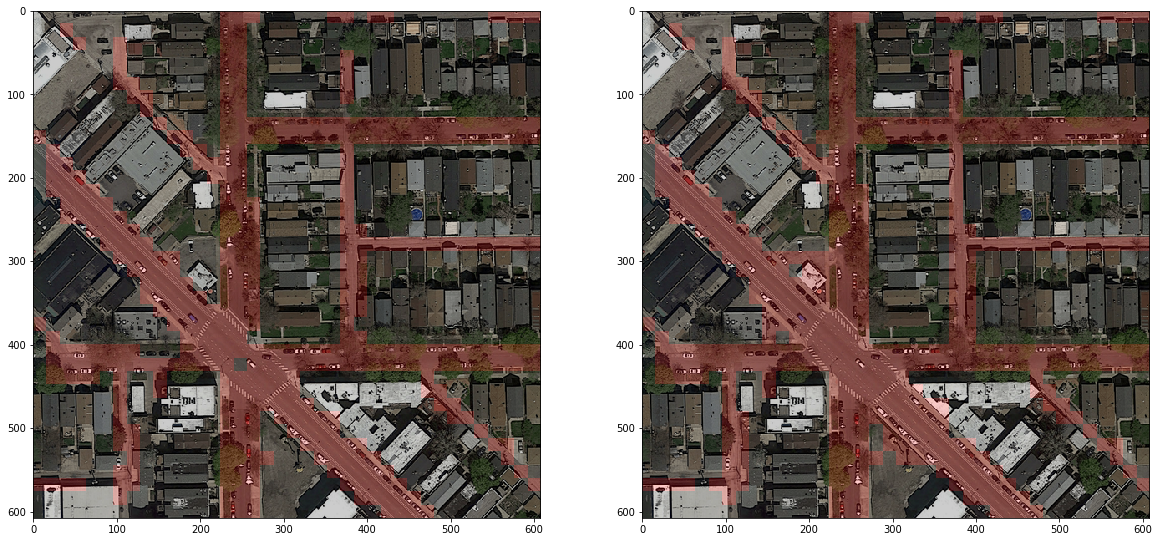

In [7]:
plt.figure(figsize=[20,30])
plt.subplot(1,2,1)
plt.imshow(new_img)
plt.subplot(1,2,2)
plt.imshow(new_img2)

# post-process all the images, and then create submission

In [8]:
post_processed_labels = np.empty((50,38*38))
for i in range(50):
    patches_38x38 = test_labels[i].reshape(38,38)
    post_processed_labels[i] = post_process_single(patches_38x38,38).reshape(38*38)

In [9]:
MY_masks_to_submission('1812submission_postprocessed_2b.csv', post_processed_labels)